<a href="https://colab.research.google.com/github/RLWH/reinforcement-learning-notebook/blob/master/4.%20Model%20Free%20Control/Algorithm_implementation_Windy_Gridworld.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Windy Gridworld

## The problem

Similar to the gridworld problem but with a different setting:-
- There is a crosswind running upward through the middle of the grid.
- The actions are the standard four
    - Up, Down, Right, Left
- The strength of the wind is given below each column, in number of cells shifted upward. 

![Windy Gridworld](https://raw.githubusercontent.com/RLWH/reinforcement-learning-notebook/master/images/windy_gridworld/windy_gw.png)

## The environment

Clone from https://github.com/dennybritz/reinforcement-learning/blob/master/TD/Windy%20Gridworld%20Playground.ipynb

In [0]:
#@title Import Libraries
import gym
import numpy as np
import sys
import random
import seaborn as sns
from gym.envs.toy_text import discrete

In [0]:
#@title Environment Setup

UP = 0
RIGHT = 1
DOWN = 2
LEFT = 3

class WindyGridworldEnv(discrete.DiscreteEnv):

    metadata = {'render.modes': ['human', 'ansi']}

    def _limit_coordinates(self, coord):
        coord[0] = min(coord[0], self.shape[0] - 1)
        coord[0] = max(coord[0], 0)
        coord[1] = min(coord[1], self.shape[1] - 1)
        coord[1] = max(coord[1], 0)
        return coord

    def _calculate_transition_prob(self, current, delta, winds):
        new_position = np.array(current) + np.array(delta) + np.array([-1, 0]) * winds[tuple(current)]
        new_position = self._limit_coordinates(new_position).astype(int)
        new_state = np.ravel_multi_index(tuple(new_position), self.shape)
        is_done = tuple(new_position) == (3, 7)
        return [(1.0, new_state, -1.0, is_done)]

    def __init__(self):
        self.shape = (7, 10)

        nS = np.prod(self.shape)
        nA = 4

        # Wind strength
        winds = np.zeros(self.shape)
        winds[:,[3,4,5,8]] = 1
        winds[:,[6,7]] = 2

        # Calculate transition probabilities
        P = {}
        for s in range(nS):
            position = np.unravel_index(s, self.shape)
            P[s] = { a : [] for a in range(nA) }
            P[s][UP] = self._calculate_transition_prob(position, [-1, 0], winds)
            P[s][RIGHT] = self._calculate_transition_prob(position, [0, 1], winds)
            P[s][DOWN] = self._calculate_transition_prob(position, [1, 0], winds)
            P[s][LEFT] = self._calculate_transition_prob(position, [0, -1], winds)

        # We always start in state (3, 0)
        isd = np.zeros(nS)
        isd[np.ravel_multi_index((3,0), self.shape)] = 1.0

        super(WindyGridworldEnv, self).__init__(nS, nA, P, isd)

    def render(self, mode='human', close=False):
        self._render(mode, close)

    def _render(self, mode='human', close=False):
        if close:
            return

        outfile = StringIO() if mode == 'ansi' else sys.stdout

        for s in range(self.nS):
            position = np.unravel_index(s, self.shape)
            # print(self.s)
            if self.s == s:
                output = " x "
            elif position == (3,7):
                output = " T "
            else:
                output = " o "

            if position[1] == 0:
                output = output.lstrip()
            if position[1] == self.shape[1] - 1:
                output = output.rstrip()
                output += "\n"

            outfile.write(output)
        outfile.write("\n")

## Environment try out

In [0]:
# Try out the environment
env = WindyGridworldEnv()

In [0]:
env.reset()
print(env.render())

o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

None


In [0]:
env.step(1)
print(env.render())

o  o  o  o  o  o  o  o  x  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

None


In [0]:
env.observation_space.n

70

In [0]:
env.action_space.n

4

# Algorithms

#### Libraries

In [0]:
def random_policy(observations, env):
    return env.action_space.sample()

In [0]:
def epsilon_greedy_policy(qs, env, eps=1e-3):
    """
    Epsilon Greedy Policy
    """
    if random.uniform(0, 1) < eps:
        return env.action_space.sample()
    else:
        return np.argmax(qs)

## MC Control Learning Agent

In [0]:
#@title MC Control Learning Agent

def generate_episode_random(env, verbose=False):
    """
    Generate a sequence according to the policy
    """
    
    states, actions, rewards = [], [], []
    
    observation = env.reset()
    while True:
        if verbose:
            print_observation(observation)
        states.append(observation)
        action = random_policy(observation, env)
        if verbose:
            print("Action taken: %s" % action)
        actions.append(action)
        observation, reward, done, info = env.step(action)
        rewards.append(reward)
        
        if done:
            if verbose:
                print("Game end. End state: %s; Reward: %s" % (observation, reward))
            break
            
    return states, actions, rewards

def mc_control(env, num_episodes=200, gamma=1.0, eps=0.3):
    """
    Monte Carlo Control Policy
    """
    
    Q = np.zeros([env.observation_space.n, env.action_space.n])
    N = np.zeros([env.observation_space.n, env.action_space.n])
    
    for i in range(num_episodes):
        
        if i % 50 == 0:
            print("%s/%s episodes done." % (i, num_episodes))
        
        states, actions, rewards = generate_episode_random(env)
        
        G = 0
        
        for t in range(len(states)):
            R = rewards[t]
            A = actions[t]
            S = states[t]
            G = gamma * G + R
            
            # Track only the first visit
            if (S, A) not in zip(states[:t], actions[:t]):
                N[S][A] += 1
                Q[S][A] += (G + Q[S][A]) / N[S][A]
                
    return Q    

In [0]:
%%time
Q = mc_control(env)

0/200 episodes done.
50/200 episodes done.
100/200 episodes done.
150/200 episodes done.
CPU times: user 1min 39s, sys: 26 ms, total: 1min 39s
Wall time: 1min 39s


In [0]:
env.reset()

30

## SARSA(0) Learning Agent

In [0]:
#@title SARSA(0) Learning Agent

def sarsa_update(env, num_episodes, alpha=0.9, gamma=1.0, eps=0.3):
    """
    SARSA(0) update algorithm
    """
    
    # Initialise Q(s,a) for all states
    Q = np.zeros([env.observation_space.n, env.action_space.n])
    ep_length_list = []
    
    for i in range(num_episodes):
        
        S = env.reset()
        # Select an action from the policy
        A = epsilon_greedy_policy(Q[S], env, eps=eps)     
        
        ep_length = 0
        
        while True:

            # Step, get next state and reward
            NS, R, done, _ = env.step(A)
            
            # Select the next action by given next state
            next_A = epsilon_greedy_policy(Q[NS], env, eps=eps)
            
            # Update Q
            Q[S][A] += alpha * (R + gamma * Q[NS][next_A] - Q[S][A])
            
            if done:
                ep_length_list.append(ep_length)
                break
            
            # Update state and action
            S = NS
            A = next_A
            
            # Add ep length
            ep_length += 1
            
    return Q, ep_length_list        

In [0]:
%%time
Q, ep_length_list = sarsa_update(env, num_episodes=10000, alpha=0.5, eps=0.1)

CPU times: user 2.64 s, sys: 991 µs, total: 2.65 s
Wall time: 2.65 s


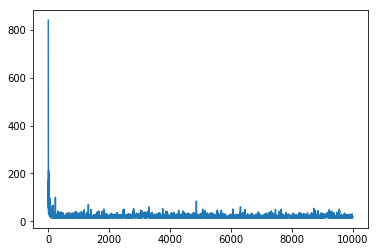

In [0]:
sns.lineplot(data=np.array(ep_length_list))

In [0]:
# Show Policy
np.argmax(Q, axis=1).reshape(7, 10)

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
       [3, 1, 1, 1, 1, 1, 0, 2, 3, 2],
       [1, 1, 1, 1, 1, 1, 1, 0, 1, 2],
       [0, 0, 0, 1, 1, 0, 1, 0, 1, 2],
       [1, 1, 1, 1, 1, 1, 0, 2, 3, 3],
       [1, 2, 2, 0, 1, 0, 0, 2, 3, 2],
       [1, 1, 1, 1, 0, 0, 0, 0, 0, 3]])

## SARSA($\lambda$) Learning Agent - Backward approach

In [0]:
def sarsa_lambda(env, num_episodes, alpha=0.5, lam=0.1, gamma=1.0, eps=0.1):
    """
    SARSA Lambda algorithm - Backward
    """
    
    Q = np.zeros([env.observation_space.n, env.action_space.n])
    ep_length_list = []
    
    for i in range(num_episodes):
        
        # Initialise eligibility trace
        E = np.zeros([env.observation_space.n, env.action_space.n])
        
        # Initialise S, A
        S = env.reset()
        A = epsilon_greedy_policy(Q[S], env, eps=eps)
        
        # Initialise ep_length
        ep_length = 0
        
        while True:
            
            # Step to get next state and rewards
            NS, R, done, _ = env.step(A)
            
            # Next action by eps-greedy
            NA = epsilon_greedy_policy(Q[NS], env, eps=eps)
            
            # Calculate TD arror
            delta = R + gamma * Q[NS][NA] - Q[S][A]
            
            # Add the eligibility trace
            E[S][A] += 1
            
            # Update the Q value by eligibility trace
            Q += alpha * delta * E
            E = gamma * lam * E
            
            if done:
                ep_length_list.append(ep_length)
                break
                
            S = NS
            A = NA
            
            # Add ep length
            ep_length += 1

    return Q, ep_length_list
            

In [0]:
%%time
Q, ep_length_list = sarsa_lambda(env, num_episodes=10000, lam=0.1, alpha=0.5, eps=0.1)

CPU times: user 3.57 s, sys: 2.13 ms, total: 3.58 s
Wall time: 3.58 s


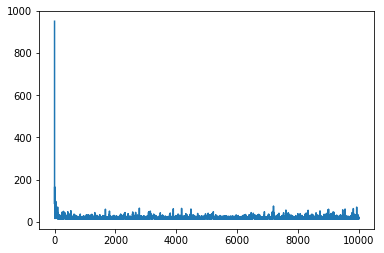

In [0]:
sns.lineplot(data=np.array(ep_length_list))

In [0]:
# Show Policy
np.argmax(Q, axis=1).reshape(7, 10)

array([[2, 1, 1, 1, 1, 1, 1, 1, 1, 2],
       [1, 1, 1, 1, 1, 1, 0, 1, 3, 2],
       [1, 1, 1, 1, 1, 1, 1, 1, 0, 2],
       [1, 1, 1, 1, 1, 1, 3, 0, 1, 2],
       [1, 1, 2, 1, 1, 1, 0, 2, 3, 3],
       [1, 1, 1, 1, 0, 0, 0, 2, 1, 2],
       [2, 0, 1, 1, 0, 0, 0, 0, 3, 3]])

## Q-learning Agent

In [0]:
def q_learning_agent(env, num_episodes, alpha=0.5, gamma=1.0, eps=0.1):
    """
    Q-learning agent
    Target policy always greedy
    Behavioural policy always eps-greedy
    """
    
    Q = np.zeros([env.observation_space.n, env.action_space.n])
    ep_length_list = []
    
    for i in num_episodes:
        
        S = env.reset()
        ep_length = 0
        
        while True:
            
            # Sample A from eps-greedy policy
            A = epsilon_greedy_policy(Q[S], env, eps=eps)
            
            # Step to get next state and reward
            NS, R, done, _ = env.step(A)
            
            # Sample a from greedy policy by given next state
            a = epsilon_greedy_policy(Q[NS], env, eps=-1)
            
            # Update Q
            Q[S][A] += alpha * (R + gamma * Q[NS][a] - Q[S][A])
            
            if done:
                ep_length_list.append(ep_length)
                break
                
            S = NS
            ep_length += 1
    
    return Q, ep_length_list

In [0]:
%%time
Q, ep_length_list = sarsa_lambda(env, num_episodes=10000, alpha=0.5, eps=0.1)

CPU times: user 3.99 s, sys: 4.16 ms, total: 3.99 s
Wall time: 3.99 s


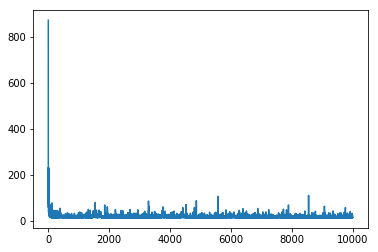

In [0]:
sns.lineplot(data=np.array(ep_length_list))

In [0]:
# Show Policy
np.argmax(Q, axis=1).reshape(7, 10)

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
       [1, 1, 1, 1, 1, 1, 1, 2, 1, 2],
       [1, 0, 1, 1, 1, 1, 1, 0, 0, 2],
       [1, 1, 1, 1, 1, 1, 1, 0, 1, 2],
       [1, 1, 1, 1, 1, 1, 0, 2, 3, 3],
       [2, 1, 1, 1, 1, 0, 0, 1, 1, 3],
       [1, 1, 1, 1, 0, 0, 0, 0, 2, 0]])